In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset, default_collate
from torchvision.transforms import ToTensor
import timm
from torch.optim.lr_scheduler import _LRScheduler
import math

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
TRAIN_DIR = os.path.join("./train")

In [4]:
df = pd.read_csv(os.path.join("./", "labels.csv"))
df["id"] = df["id"].apply(lambda x: os.path.join(TRAIN_DIR, x+".jpg"))

labels = sorted(df["breed"].unique())
label_to_int = {breed:i for i, breed in enumerate(labels)}
int_to_label = {i:breed for i, breed in enumerate(labels)}

In [5]:
val_size = int(len(df) * 0.1)
indices = np.random.choice(len(df)-1, replace=False, size=val_size)
df_train = df.drop(indices)
df_test = df.iloc[indices]

print(len(df_train), len(df_test))

9200 1022


In [6]:
class DogBreedDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, target_transform=None):
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
class Cutout(object):
    def __init__(self, n_holes, length, prob=0.5):
        self.n_holes = n_holes
        self.length = length
        self.prob = prob

    def __call__(self, img):
        
        if np.random.rand() > self.prob:
            return img
        
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [8]:
transform_train = v2.Compose([
    v2.Resize((224,224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    Cutout(1, 56)
])

transform_test = v2.Compose([
    v2.Resize((224,224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_train = DogBreedDataset(
    df_train,
    TRAIN_DIR,
    transform_train,
    lambda x: label_to_int[x]
)

dataset_test = DogBreedDataset(
    df_test,
    TRAIN_DIR,
    transform_test,
    lambda x: label_to_int[x]
)

In [9]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=64,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                          shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


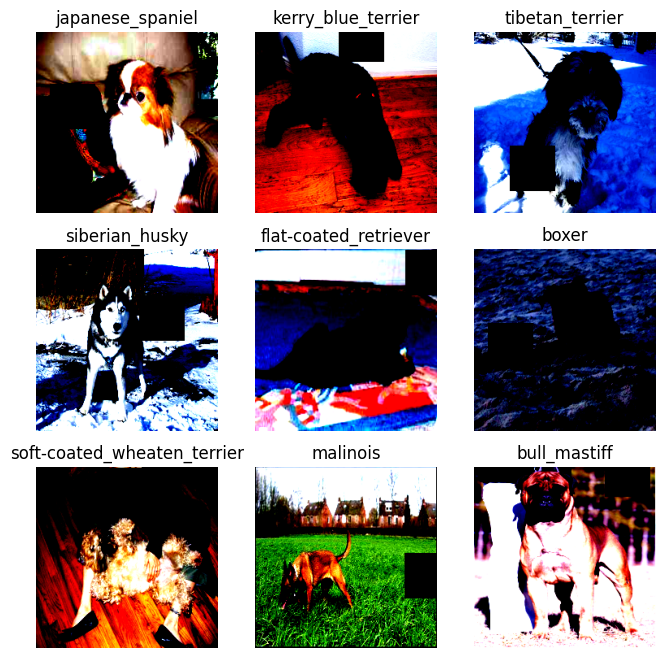

In [10]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
    img, label = dataset_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(int_to_label[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

In [11]:
def accuracy(outputs, labels):
    with torch.no_grad():
        _, preds = torch.max(outputs, dim=1)
        return torch.sum(preds == labels).item() / len(preds)
    
def validate(model, dataset, criterion):
    correct = 0
    total = 0
    running_loss = 0.0
    
    with torch.no_grad():
        for i, data in enumerate(dataset):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            
            # val loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # val accuracy
            _, preds = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    
    return running_loss / (i+1), correct / total

In [12]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train(model, optimizer, criterion, train_loader, test_loader, epochs=10, scheduler=None):
    counter = 0
    total_train_losses = []  # 전체 학습 손실을 기록할 리스트
    total_val_losses = []  # 전체 검증 손실을 기록할 리스트
    
    for epoch in range(epochs):
        
        if counter > 5:
            print("Early Stopping")
            break
        
        model.train()  # 모델을 학습 모드로 설정
        train_losses, train_accs = [], []
        
        # tqdm 라이브러리를 사용하여 학습 진행도를 표시
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            # Train statistics
            train_losses.append(loss.item())
            # train_accs.append(accuracy(outputs, labels))  # 정확도 계산 함수가 정의되어 있어야 합니다.

        total_train_losses.extend(train_losses)  # 에폭별 손실을 전체 리스트에 추가
        
        # 검증 단계, 모델을 평가 모드로 설정
        model.eval()  
        val_losses, val_accs = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_losses.append(loss.item())
                # val_accs.append(accuracy(outputs, labels))

        total_val_losses.extend(val_losses)  # 에폭별 손실을 전체 리스트에 추가

        # Learning Rate Scheduler
        if scheduler is not None:
            scheduler.step()

        if (epoch + 1) % 10 == 0:  # 10 에폭마다 평균 손실과 정확도 출력
            avg_train_loss = sum(train_losses) / len(train_losses)
            avg_val_loss = sum(val_losses) / len(val_losses)
            print(f'\n[{epoch + 1}] Train loss: {avg_train_loss:.3f}, Val loss: {avg_val_loss:.3f}')
            print(f"LR: {optimizer.param_groups[0]['lr']:.7f}")
    
    print('Finished Training')
    
    # 학습 및 검증 손실 그래프 그리기
    plt.plot(total_train_losses, label='Train Loss')
    plt.plot(total_val_losses, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [13]:
#(classifier): Linear(in_features=1024, out_features=1000, bias=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model = timm.create_model('efficientnet_b4', pretrained=True)
model.classifier = nn.Linear(1792, len(labels))
#b4=1792
#b0-1280
model.to(device)
# model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
    

In [14]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [ ]:
criterion = nn.CrossEntropyLoss()
#, weight_decay=4e-5
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=4e-5)
# scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=150, T_mult=1, eta_max=0.1,  T_up=10, gamma=0.5)
train(model, optimizer, criterion,train_loader, test_loader, 200, scheduler)

Epoch 10/200: 100%|██████████████████████████████████████████████████████████████████████| 144/144 [18:56<00:00,  7.90s/batch]



[10] Train loss: 5.148, Val loss: 12.769
LR: 0.1000000


Epoch 20/200: 100%|██████████████████████████████████████████████████████████████████████| 144/144 [18:55<00:00,  7.89s/batch]



[20] Train loss: 5.013, Val loss: 5.152
LR: 0.0987589


Epoch 30/200: 100%|██████████████████████████████████████████████████████████████████████| 144/144 [18:37<00:00,  7.76s/batch]



[30] Train loss: 4.927, Val loss: 5.226
LR: 0.0950980


Epoch 40/200: 100%|██████████████████████████████████████████████████████████████████████| 144/144 [17:36<00:00,  7.34s/batch]



[40] Train loss: 4.934, Val loss: 7.761
LR: 0.0892007


Epoch 42/200:  78%|██████████████████████████████████████████████████████▍               | 112/144 [14:27<04:14,  7.95s/batch]

In [ ]:
torch.save(model, "model.pt")

In [ ]:
y_true = []
y_pred = []
 
with torch.no_grad():
    for data in test_loader:
        images, lbs = data[0].to(device),data[1].to(device)

        y_true.extend(lbs.cpu().numpy())

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

print(f'F1 Score: {f1_score(y_true, y_pred, average="weighted"):.3f}')
print(f'Accuracy: {accuracy_score(y_true, y_pred):.3f}')
